In [1]:
require(rpart)
require(randomForest)
require(RColorBrewer)
require(rattle)
require(rpart.plot)
require(party)

Loading required package: rpart
Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Loading required package: RColorBrewer
Loading required package: rattle
Rattle: A free graphical interface for data mining with R.
Versión 4.1.0 Copyright (c) 2006-2015 Togaware Pty Ltd.
Escriba 'rattle()' para agitar, sacudir y  rotar sus datos.
Loading required package: rpart.plot
Loading required package: party
Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich


In [2]:
d.all <- read.csv(file.path("..","data", "final", "clean.csv"))
head(d.all)

ID,magnitude,Cadence,duration,latitude,longitude,Teff,Teff_error,logg,logg_error,Type,var_lc,num_peaks,median_peaks,mad_peaks
1,16.8,1800,27.38,9.84,108.10,4354,300,-999.00,-999.00,Trans/Eclipse,2.572494e+00,2,29.86858,41.75269
2,6.0,1800,82.17,65.38,108.08,8000,200,-999.00,-999.00,Trans/Eclipse,9.459850e+05,19,57.12909,55.69576
3,15.5,1800,27.37,49.41,246.24,2754,250,-999.00,-999.00,LPV;MIRA,2.589982e+02,2,31.12475,11.37836
4,13.8,120,27.40,42.44,226.11,16160,130,3.91,0.16,SPB,4.066555e+01,9,127.49338,68.59015
5,14.6,20,27.40,52.68,180.44,8000,200,-999.00,-999.00,Trans/Eclipse,1.204713e-01,611,4899.64632,4507.44102
6,10.3,1800,54.79,40.29,283.81,2780,250,-999.00,-999.00,LPV;MIRA,6.048815e+06,2,28.92632,14.50562


In [3]:
set.seed(1)

sample_size <- floor(0.75 * nrow(d.all))

d.train_ind <- sample(seq_len(nrow(d.all)), size = sample_size)

d.train <- d.all[d.train_ind, ]
d.test  <- d.all[-d.train_ind, ]

In [4]:
str(d.all)

'data.frame':	2500 obs. of  15 variables:
 $ ID          : int  1 2 3 4 5 6 7 8 9 10 ...
 $ magnitude   : num  16.8 6 15.5 13.8 14.6 10.3 7.7 12.7 16.5 13 ...
 $ Cadence     : int  1800 1800 1800 120 20 1800 1800 1800 120 120 ...
 $ duration    : num  27.4 82.2 27.4 27.4 27.4 ...
 $ latitude    : num  9.84 65.38 49.41 42.44 52.68 ...
 $ longitude   : num  108 108 246 226 180 ...
 $ Teff        : int  4354 8000 2754 16160 8000 2780 4601 5661 11990 28840 ...
 $ Teff_error  : int  300 200 250 130 200 250 200 300 60 100 ...
 $ logg        : num  -999 -999 -999 3.91 -999 -999 3.29 -999 4.27 3.81 ...
 $ logg_error  : num  -999 -999 -999 0.16 -999 -999 0.1 -999 0.09 0.1 ...
 $ Type        : Factor w/ 26 levels " bCep"," Cepheid;blher",..: 26 26 13 25 26 13 21 26 25 25 ...
 $ var_lc      : num  2.57 9.46e+05 2.59e+02 4.07e+01 1.20e-01 ...
 $ num_peaks   : int  2 19 2 9 611 2 1 NA 30 213 ...
 $ median_peaks: num  29.9 57.1 31.1 127.5 4899.6 ...
 $ mad_peaks   : num  41.8 55.7 11.4 68.6 4507.4 .

## Simple decision tree

Warning message in polygon(x[, i], y[, i], col = col[i], border = border.col[i], :
“semi-transparencia no esta soportado en este dispositivo: reportado solo una vez por pagina”

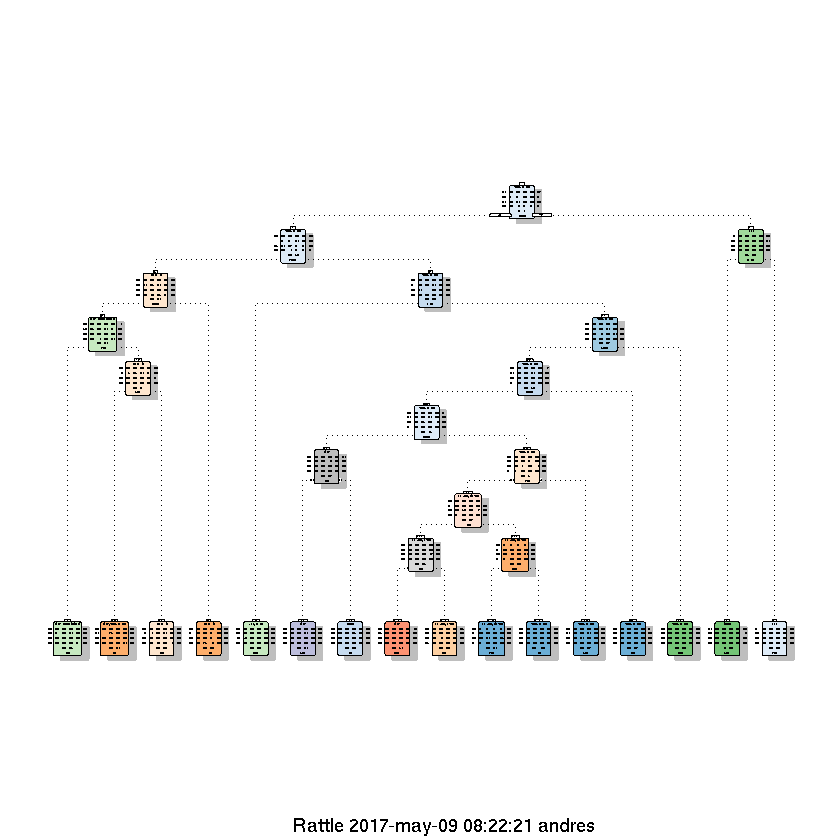

In [5]:
fit.tree <- rpart(Type ~ magnitude + Teff + logg + num_peaks + median_peaks + mad_peaks,
                  data = d.train, method = "class")
fit.tree.prediction <- predict(fit.tree, d.test, type = "class")
fancyRpartPlot(fit.tree)

In [6]:
paste("Training error:",
      sum(predict(fit.tree, d.train, type = "class") == d.train$Type) / nrow(d.train) * 100, "%")
paste("Prediction error:",
      sum(predict(fit.tree, d.test, type = "class") == d.test$Type) / nrow(d.test) * 100, "%")

[1] "Training error: 79.52 %"

[1] "Prediction error: 79.2 %"

## Random forest

In [7]:
d.train[is.na(d.train$num_peaks), "median_peaks"] <- 0
d.train[is.na(d.train$num_peaks), "mad_peaks"] <- 0
d.train[is.na(d.train$num_peaks), "num_peaks"] <- 0

d.test[is.na(d.test$num_peaks), "median_peaks"] <- 0
d.test[is.na(d.test$num_peaks), "mad_peaks"] <- 0
d.test[is.na(d.test$num_peaks), "num_peaks"] <- 0

### Feature importances

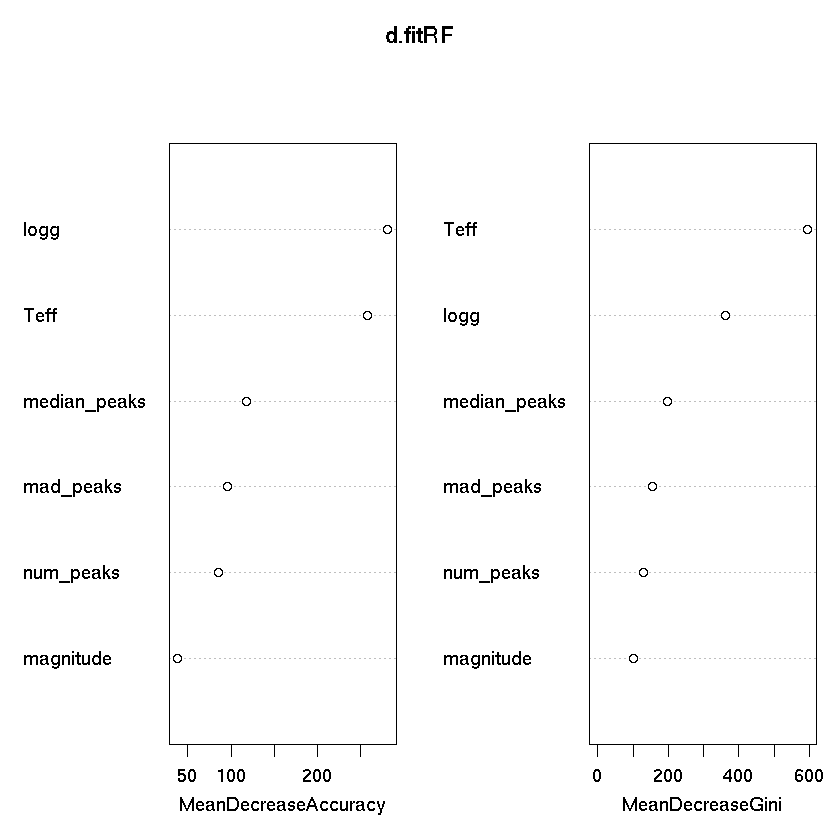

In [8]:
d.fitRF <- randomForest(Type ~ magnitude + Teff + logg + num_peaks + median_peaks + mad_peaks,
                        data = d.train,
                        importance = TRUE, ntree = 2000)
varImpPlot(d.fitRF)

In [9]:
## Make the predictions
paste("Training error:",
      sum(predict(d.fitRF, d.train, type = "class") == d.train$Type) / nrow(d.train) * 100, "%")
paste("Prediction error:",
      sum(predict(d.fitRF, d.test, type = "class") == d.test$Type) / nrow(d.test) * 100, "%")

[1] "Training error: 99.4133333333333 %"

[1] "Prediction error: 86.72 %"